In [1]:
import torch

In [2]:
torch.__version__

'2.2.2'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
x = torch.rand(5, 3).to(device)

In [5]:
x

tensor([[0.7287, 0.5817, 0.7032],
        [0.2094, 0.6107, 0.8822],
        [0.0397, 0.7963, 0.3732],
        [0.8447, 0.3750, 0.6566],
        [0.7264, 0.8184, 0.1894]])

# K-Means

In [6]:
import matplotlib.pyplot as plt

In [7]:
N = 100
x1 = torch.randn(N, 2)
x2 = torch.randn(N, 2) + torch.Tensor([3, 3])
x3 = torch.randn(N, 2) + torch.Tensor([-3, 3])

In [8]:
X = torch.cat([x1, x2, x3], dim=0)
print(X.shape)

torch.Size([300, 2])


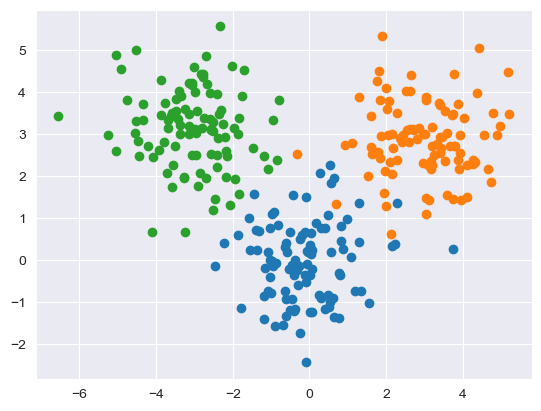

In [9]:
for i in range(3):
    plt.scatter(X[i*N:(i+1)*N, 0], X[i*N:(i+1)*N, 1])
plt.show()

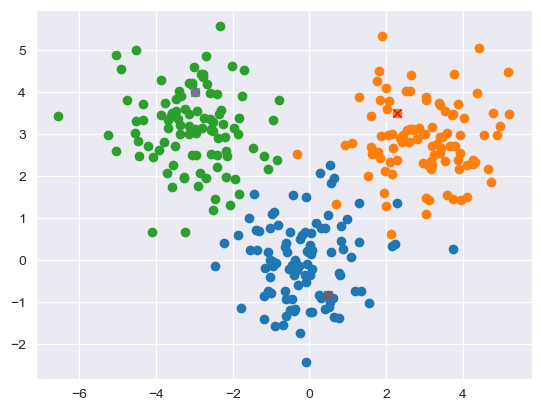

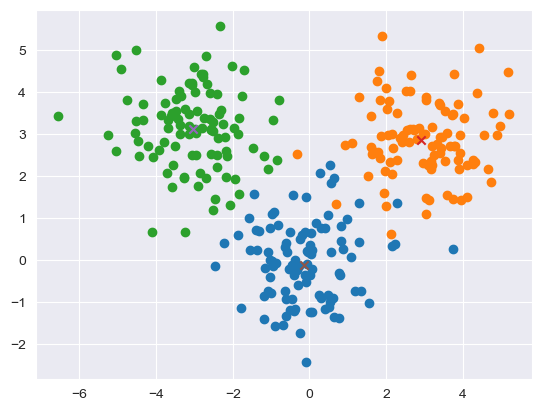

In [10]:
K = 3
centroids = X[torch.randperm(len(X))[:K]]
while True:
    D = torch.cdist(X, centroids)
    clusters = torch.argmin(D, dim=1)
    for i in range(3):
        plt.scatter(X[i*N:(i+1)*N, 0], X[i*N:(i+1)*N, 1])
    old_centroids = centroids.clone()
    for k in range(K):
        plt.scatter(centroids[k, 0], centroids[k, 1], marker='x')
        centroids[k] = X[clusters == k].mean(dim=0)
    change = torch.sum((centroids - old_centroids) ** 2)
    if change < 0.1:
        break
    plt.show()

In [11]:
import time
device = 'cpu'

N = 100000
x1 = torch.randn(N, 2)
x2 = torch.randn(N, 2) + torch.Tensor([3, 3])
x3 = torch.randn(N, 2) + torch.Tensor([-3, 3])
X = torch.cat([x1, x2, x3], dim=0).to(device)

t1 = time.time()
K = 3
centroids = X[torch.randperm(len(X))[:K]]
for _ in range(100):
    D = torch.cdist(X, centroids)
    clusters = torch.argmin(D, dim=1)
    for k in range(K):
        centroids[k] = X[clusters == k].mean(dim=0)
print(time.time() - t1)

3.0250399112701416


# Auto differentiation

In [12]:
x = torch.tensor(3., requires_grad=True)
y = x**2 + 2*x + 1 
# y' = 2x + 2
y.backward()

In [13]:
x.grad # 2(3) + 2

tensor(8.)

# Regression

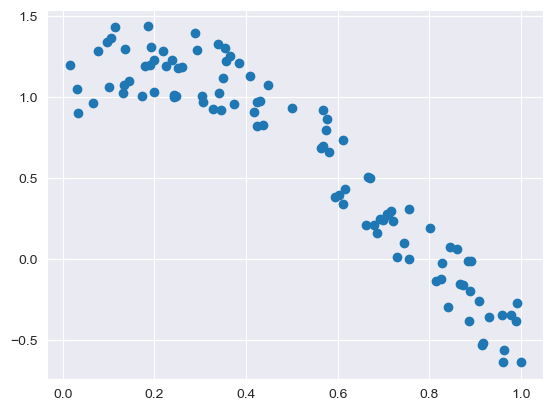

In [14]:
N = 100
x = torch.rand(N, 1)
y = torch.sin(3 * x + 1) + 0.5 * torch.rand(N, 1)
plt.scatter(x, y)

In [15]:
ones = torch.ones(N, 1)
X = torch.cat([x, ones], dim=1)

In [16]:
R = torch.inverse(X.T @ X) @ X.T @ y

In [17]:
x_ = torch.linspace(0, 1, 100).reshape(-1, 1)

In [18]:
y_ = x_ * R[0] + R[1]

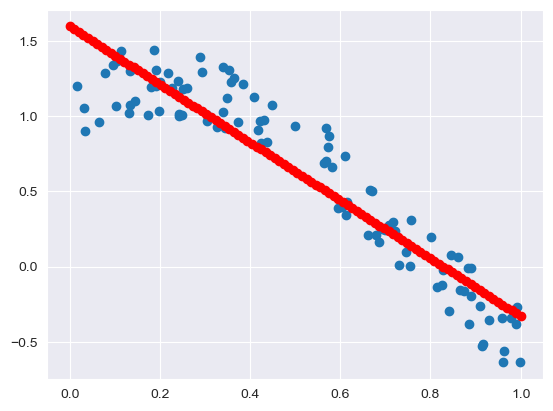

In [19]:
plt.scatter(x, y)
plt.scatter(x_, y_, color='r')
plt.show()

## Nonlinear

In [20]:
ones = torch.ones(N, 1)
X = torch.cat([x**2, x, ones], dim=1)

In [21]:
R = torch.inverse(X.T @ X) @ X.T @ y

In [22]:
y_ = x_**2 * R[0] + x_ * R[1] + R[2]

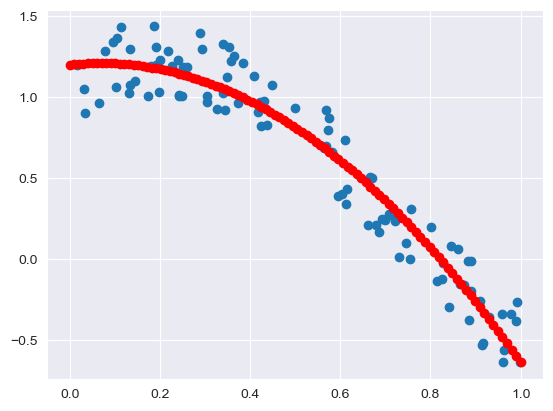

In [23]:
plt.scatter(x, y)
plt.scatter(x_, y_, color='r')
plt.show()

In [24]:
device = 'cpu'

N = 100000000
x = torch.rand(N, 1).to(device)
y = torch.sin(3 * x + 1) + 0.5 * torch.rand(N, 1).to(device)

t1 = time.time()
degree = 1
ones = torch.ones(N, 1).to(device)
X = torch.cat([x, ones], dim=1)
for i in range(2, degree + 1):
    X = torch.cat([x**i, X], dim=1)
R = torch.inverse(X.T @ X) @ X.T @ y
print(time.time() - t1)

1.3028807640075684


# MLP

In [25]:
from torch import nn

In [26]:
# [1] 32 16 [1]
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return self.fc3(x)

In [27]:
(1*32+32) + (32*16+16) + (16*1+1)

609

In [28]:
model = Regressor()

In [29]:
gen = iter(model.parameters())

In [30]:
next(gen).shape

torch.Size([32, 1])

In [31]:
N = 1000
x = torch.rand(N, 1).to(device)
y = torch.sin(3 * x + 1) + 0.5 * torch.rand(N, 1).to(device)

In [32]:
device = 'cpu' 

model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

model.train()
for epoch in range(5000):
    y_ = model(x.to(device))
    loss = criterion(y_, y.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'{epoch}: {loss.item()}')

0: 0.3618209958076477
100: 0.33612746000289917
200: 0.3062989115715027
300: 0.239244282245636
400: 0.1288558542728424
500: 0.0634509027004242
600: 0.0531909205019474
700: 0.05095454305410385
800: 0.04929836839437485
900: 0.04787367954850197
1000: 0.0466095395386219
1100: 0.04545845836400986
1200: 0.04438992589712143
1300: 0.04338432475924492
1400: 0.04242900013923645
1500: 0.04151582717895508
1600: 0.04063957929611206
1700: 0.039796989411115646
1800: 0.03898603096604347
1900: 0.03820545971393585
2000: 0.03745453059673309
2100: 0.03673286363482475
2200: 0.036040298640728
2300: 0.03537680208683014
2400: 0.034742459654808044
2500: 0.03413734957575798
2600: 0.033561576157808304
2700: 0.0330151803791523
2800: 0.03249811381101608
2900: 0.03201024606823921
3000: 0.0315513089299202
3100: 0.03112088330090046
3200: 0.030718402937054634
3300: 0.030343182384967804
3400: 0.029994364827871323
3500: 0.029670966789126396
3600: 0.029371894896030426
3700: 0.029095947742462158
3800: 0.02884184941649437
3

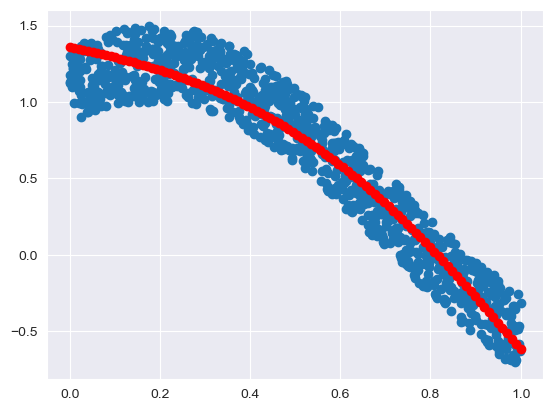

In [33]:
x_ = torch.linspace(0, 1, 100).reshape(-1, 1)
model.eval()
with torch.no_grad():
    y_ = model(x_.to(device))
plt.scatter(x, y)
plt.scatter(x_, y_.cpu(), color='r')
plt.show()

# Classification

In [34]:
N = 100
x1 = torch.randn(N, 2)
x2 = torch.randn(N, 2) + torch.Tensor([3, 3])
x3 = torch.randn(N, 2) + torch.Tensor([-3, 3])

In [35]:
X = torch.cat([x1, x2, x3], dim=0)
print(X.shape)

torch.Size([300, 2])


In [36]:
N

100

In [37]:
X.shape

torch.Size([300, 2])

In [38]:
Y = torch.cat([torch.zeros(N), torch.ones(N), torch.ones(N) * 2]).long()

In [39]:
Y.shape

torch.Size([300])

In [40]:
X.shape[1]

2

In [41]:
len(Y.unique())

3

In [42]:
# [2] 32 16 [3]
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 3)
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [43]:
model = Classifier()

In [44]:
device = 'cpu' 

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

model.train()
for epoch in range(5000):
    y_ = model(X.to(device))
    loss = criterion(y_, Y.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'{epoch}: {loss.item()}')

0: 1.0979130268096924
100: 1.0894804000854492
200: 1.0779520273208618
300: 1.0577641725540161
400: 1.0225167274475098
500: 0.9711728692054749
600: 0.9184194207191467
700: 0.879042387008667
800: 0.8525424599647522
900: 0.8335327506065369
1000: 0.8182289600372314
1100: 0.8045413494110107
1200: 0.7913426160812378
1300: 0.7780502438545227
1400: 0.7644361853599548
1500: 0.7505282163619995
1600: 0.7365304231643677
1700: 0.7227427959442139
1800: 0.7094831466674805
1900: 0.697024941444397
2000: 0.6855607628822327
2100: 0.6751914024353027
2200: 0.6659363508224487
2300: 0.6577531099319458
2400: 0.6505604982376099
2500: 0.6442574262619019
2600: 0.6387380361557007
2700: 0.63390052318573
2800: 0.6296510696411133
2900: 0.6259077191352844
3000: 0.6225984692573547
3100: 0.6196620464324951
3200: 0.6170462965965271
3300: 0.6147071123123169
3400: 0.612606942653656
3500: 0.6107139587402344
3600: 0.6090013980865479
3700: 0.6074464321136475
3800: 0.6060293316841125
3900: 0.6047337651252747
4000: 0.603545308

In [45]:
model.eval()
with torch.no_grad():
    y_ = model(X.to(device))
acc = torch.sum(Y == y_.argmax(dim=1).cpu()) / len(Y)
print(acc.item())

0.9800000190734863


In [46]:
from sklearn.datasets import load_iris
import numpy as np
df = load_iris(as_frame=True)

In [47]:
itrain = np.r_[0:25, 50:75, 100:125]
itest = np.r_[25:50, 75:100, 125:150]
xtrain = df['data'].iloc[itrain].values
xtest = df['data'].iloc[itest].values
ytrain = df['target'].iloc[itrain].values
ytest = df['target'].iloc[itest].values

In [48]:
xtrain.shape

(75, 4)

In [49]:
len(np.unique(ytrain))

3

In [50]:
# [4] 128 [3]
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 3)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=1)

In [51]:
xtrain_ = torch.tensor(xtrain, dtype=torch.float32)

In [52]:
xtest_ = torch.tensor(xtrain, dtype=torch.float32)

In [53]:
ytrain_ = torch.tensor(ytrain, dtype=torch.long)

In [54]:
ytest_ = torch.tensor(ytrain, dtype=torch.long)

In [55]:
model = Classifier()

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(5000):
    y_ = model(xtrain_.to(device))
    loss = criterion(y_, ytrain_.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'{epoch}: {loss.item()}')

0: 1.0662072896957397
100: 0.572624921798706
200: 0.5627980828285217
300: 0.5577839612960815
400: 0.5550016760826111
500: 0.5535830855369568
600: 0.5528351068496704
700: 0.5524092316627502
800: 0.5521481037139893
900: 0.5519778728485107
1000: 0.5518613457679749
1100: 0.551778256893158
1200: 0.5517169833183289
1300: 0.5516706109046936
1400: 0.5516347289085388
1500: 0.5516064167022705
1600: 0.5515837073326111
1700: 0.5515651702880859
1800: 0.5515499114990234
1900: 0.5515372157096863
2000: 0.5515264868736267
2100: 0.5515173077583313
2200: 0.5515096187591553
2300: 0.5515028834342957
2400: 0.5514970421791077
2500: 0.5514919757843018
2600: 0.5514875054359436
2700: 0.551483690738678
2800: 0.5514801740646362
2900: 0.5514770746231079
3000: 0.5514742732048035
3100: 0.5514718890190125
3200: 0.5514695644378662
3300: 0.5514675974845886
3400: 0.5514658689498901
3500: 0.5514642000198364
3600: 0.551462709903717
3700: 0.5514613389968872
3800: 0.5514600872993469
3900: 0.551459014415741
4000: 0.551458001

In [57]:
model.eval()
with torch.no_grad():
    y_ = model(xtest_.to(device))
acc = torch.sum(ytest_ == y_.argmax(dim=1).cpu()) / len(y_)
print(acc.item())

1.0


In [58]:
torch.save(model.state_dict(), 'model.pth')

In [59]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.4970, -0.2614,  0.3488,  2.0546],
                      [-0.1880, -0.1196, -0.1820, -0.4397],
                      [ 0.3186,  0.4893, -0.1631, -0.9050],
                      [ 0.1980, -0.5421,  1.0424,  0.9724],
                      [-0.1079,  0.2667,  0.4934, -1.1199],
                      [-0.3677, -0.3454,  0.2887, -0.3221],
                      [-0.2974, -0.3348, -0.3805, -0.4525],
                      [ 0.4779,  0.5822, -0.1852, -1.2382],
                      [ 0.5225,  0.1861, -0.2876, -0.6540],
                      [-0.2540, -0.3678,  0.0383, -0.4771],
                      [ 0.5086, -0.0129, -0.3905, -1.2133],
                      [ 0.1295, -0.5680,  0.8863,  1.9470],
                      [ 0.2691, -0.4629,  0.4527,  0.9657],
                      [ 0.6093,  0.5130, -0.6728, -1.9002],
                      [ 0.0324, -0.2088,  0.3426,  1.3001],
                      [-0.3925, -0.3086,  0.0458,  0.1079],
            

In [60]:
df['data'].columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [61]:
df['data'].max()

sepal length (cm)    7.9
sepal width (cm)     4.4
petal length (cm)    6.9
petal width (cm)     2.5
dtype: float64

In [62]:
import seaborn as sns

In [63]:
df = sns.load_dataset('titanic')
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [64]:
df.nunique()

survived         2
pclass           3
sex              2
age             88
sibsp            7
parch            7
fare           248
embarked         3
class            3
who              3
adult_male       2
deck             7
embark_town      3
alive            2
alone            2
dtype: int64

In [65]:
df = df.drop(columns=['class', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'])

In [66]:
import pandas as pd

In [67]:
df = pd.get_dummies(df, dtype=float)

In [68]:
df

,survived,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,who_child,who_man,who_woman
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
887,1,1,19.0,0,0,30.0000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
888,0,3,NaN,1,2,23.4500,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,1,1,26.0,0,0,30.0000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [69]:
df = df.drop(columns=['sex_female'])

In [70]:
df

,survived,pclass,age,sibsp,parch,fare,sex_male,embarked_C,embarked_Q,embarked_S,who_child,who_man,who_woman
0,0,3,22.0,1,0,7.2500,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,1,38.0,1,0,71.2833,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,3,26.0,0,0,7.9250,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,1.0,0.0,0.0,1.0,0.0,1.0,0.0
887,1,1,19.0,0,0,30.0000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
888,0,3,NaN,1,2,23.4500,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,1,1,26.0,0,0,30.0000,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [71]:
df = df.dropna()

In [72]:
X = df.iloc[:, 1:]
Y = df.iloc[:, 0]

In [73]:
X

,pclass,age,sibsp,parch,fare,sex_male,embarked_C,embarked_Q,embarked_S,who_child,who_man,who_woman
0,3,22.0,1,0,7.2500,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,38.0,1,0,71.2833,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,3,26.0,0,0,7.9250,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,3,35.0,0,0,8.0500,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
885,3,39.0,0,5,29.1250,0.0,0.0,1.0,0.0,0.0,0.0,1.0
886,2,27.0,0,0,13.0000,1.0,0.0,0.0,1.0,0.0,1.0,0.0
887,1,19.0,0,0,30.0000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,1,26.0,0,0,30.0000,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [74]:
Y

0      0
1      1
2      1
3      1
4      0
      ..
885    0
886    0
887    1
889    1
890    0
Name: survived, Length: 714, dtype: int64

In [75]:
from sklearn.model_selection import train_test_split

In [76]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)

In [77]:
xtrain = torch.tensor(xtrain.values, dtype=torch.float32)
xtest = torch.tensor(xtest.values, dtype=torch.float32)
ytrain = torch.tensor(ytrain.values, dtype=torch.float32)
ytest = torch.tensor(ytest.values, dtype=torch.float32)
ytrain = ytrain.reshape(-1, 1)
ytest = ytest.reshape(-1, 1)

In [78]:
xtrain.shape

torch.Size([571, 12])

In [79]:
ytrain.unique()

tensor([0., 1.])

In [80]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(12, 128)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [81]:
model = Classifier()

In [82]:
ytrain.shape

torch.Size([571, 1])

In [83]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(5000):
    y_ = model(xtrain.to(device))
    loss = criterion(y_, ytrain.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'{epoch}: {loss.item()}')

0: 2.7379534244537354
100: 0.39636629819869995
200: 0.3541785478591919
300: 0.3165932893753052
400: 0.2980975806713104
500: 0.2644399404525757
600: 0.24933724105358124
700: 0.2379491925239563
800: 0.22680968046188354
900: 0.2832353115081787
1000: 0.21463683247566223
1100: 0.20869457721710205
1200: 0.20420776307582855
1300: 0.19740138947963715
1400: 0.19735878705978394
1500: 0.18493425846099854
1600: 0.1840403527021408
1700: 0.1846073716878891
1800: 0.17453867197036743
1900: 0.17275317013263702
2000: 0.16998296976089478
2100: 0.1764550358057022
2200: 0.19261594116687775
2300: 0.16758538782596588
2400: 0.1652115434408188
2500: 0.16299599409103394
2600: 0.16030292212963104
2700: 0.1581735759973526
2800: 0.1557510793209076
2900: 0.15327110886573792
3000: 0.14976422488689423
3100: 0.14939607679843903
3200: 0.14330697059631348
3300: 0.14221636950969696
3400: 0.1427200883626938
3500: 0.1425596922636032
3600: 0.13512544333934784
3700: 0.13640330731868744
3800: 0.13925397396087646
3900: 0.13108

In [84]:
model.eval()
with torch.no_grad():
    y_ = model(xtest.to(device))
acc = torch.sum(ytest == y_.round().cpu()) / len(y_)
print(acc.item())

0.7202796936035156
